In [6]:
import torch
import torch.nn as nn
import torch
import torchvision
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
matplotlib.style.use('ggplot')
!mkdir data
!mkdir samples
!mkdir generated

In [5]:
class LVAE(nn.Module):
    def __init__(self, in_features):
        super(LVAE, self).__init__()
        self.features = 16

        self.fc1 = nn.Linear(in_features,512)
        self.fc2 = nn.Linear(512,self.features*2)

        self.fc3 = nn.Linear(self.features,512)
        self.fc4 = nn.Linear(512,in_features)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def reparameterize(self, mu, log_var):

        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample

    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        #print('Before view',x.shape)
        x = x.view(-1, 2, self.features)
        #print('After view',x.shape)

        mu = x[:,0,:]
        log_var = x[:,1,:]

        z = self.reparameterize(mu, log_var)
        #print(z.shape)
        x = self.fc3(z)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        #print('out view',x.shape)

        return x, mu, log_var

    def decode(self,z):
        z = self.fc3(z)
        z = self.relu(z)
        z = self.fc4(z)
        z = self.sigmoid(z)
        #print('out view',x.shape)

        return z

In [7]:
def floss(loss, mu, log_var):

    LOSS = loss
    KLD  = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return LOSS + KLD

In [26]:
EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
])
train = torchvision.datasets.MNIST(
    root = './data',
    train = True,
    download = True,
    transform=transform
)

val = torchvision.datasets.MNIST(
    root = './data',
    train = False,
    download = True,
    transform=transform
)

In [11]:
train_loader = torch.utils.data.DataLoader(
        train,
        batch_size=BATCH_SIZE,
        shuffle=True)

val_loader = torch.utils.data.DataLoader(
    train,
    batch_size=BATCH_SIZE,
    shuffle=True)

In [27]:
model = LVAE(28*28)
model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr = LEARNING_RATE)
criterion = nn.BCELoss(reduction='sum')

In [28]:
training_loss = []
validation_loss = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    for i, data in tqdm(enumerate(train_loader), total=int(len(train)//train_loader.batch_size)):
        inputs, _ = data
        inputs = inputs.to(DEVICE)
        inputs = inputs.view(inputs.size(0),-1)
        optimizer.zero_grad()

        out, mu, log_var = model.forward(inputs)
        reconstruction_loss = criterion(out,inputs)
        loss = floss(reconstruction_loss,mu,log_var)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            num_rows = 8
            both = torch.cat((inputs.view(BATCH_SIZE,1,28,28)[:8],
                               out.view(BATCH_SIZE,1,28,28)[:8]
             ))
            torchvision.utils.save_image(both.cpu(),f'./samples/{epoch}_{i}.png',nrow=num_rows)

            z = np.random.normal(0,1,(64,16))
            z = torch.from_numpy(z).to(DEVICE)
            z = z.float()
            new = model.decode(z)
            new = new.view(BATCH_SIZE,1,28,28)[:8]
            torchvision.utils.save_image(new.cpu(),f'./generated/{epoch}_{i}.png',nrow=4)



    train_loss = total_loss/(len(train_loader.dataset))

    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(val_loader), total = int(len(val)/val_loader.batch_size)):
            inputs, _ = data
            inputs = inputs.to(DEVICE)
            inputs = inputs.view(inputs.size(0), -1)

            out, mu, log_var = model.forward(inputs)
            reconstruction_loss = criterion(out,inputs)
            loss = floss(reconstruction_loss, mu, log_var)
            total_loss += loss.item()

    val_loss = total_loss/(len(val_loader.dataset))

    training_loss.append(train_loss)
    validation_loss.append(val_loss)
    print(f"Train Loss: {train_loss}")
    print(f"Val Loss: {val_loss}")

938it [00:05, 172.29it/s]                         
938it [00:04, 227.78it/s]                         
  2%|▏         | 16/937 [00:00<00:05, 158.05it/s]

Train Loss: 215.8800745361328
Val Loss: 164.04961393229166


938it [00:05, 171.85it/s]                         
938it [00:03, 234.81it/s]                         
  2%|▏         | 16/937 [00:00<00:06, 152.16it/s]

Train Loss: 151.2730489013672
Val Loss: 141.09938133951823


938it [00:05, 171.41it/s]                         
938it [00:04, 227.81it/s]                         
  2%|▏         | 16/937 [00:00<00:05, 156.38it/s]

Train Loss: 134.64859645182293
Val Loss: 129.64949654947915


938it [00:05, 170.55it/s]                         
938it [00:04, 228.37it/s]                         
  2%|▏         | 16/937 [00:00<00:05, 157.68it/s]

Train Loss: 126.81781793619791
Val Loss: 124.3214139404297


938it [00:05, 169.94it/s]                         
938it [00:04, 229.44it/s]                         
  2%|▏         | 16/937 [00:00<00:05, 158.71it/s]

Train Loss: 122.56949054361979
Val Loss: 120.9106193725586


938it [00:05, 170.26it/s]                         
938it [00:04, 230.69it/s]                         
  2%|▏         | 17/937 [00:00<00:05, 161.79it/s]

Train Loss: 119.79254817708333
Val Loss: 118.6385012084961


938it [00:05, 172.17it/s]                         
938it [00:04, 230.23it/s]                         
  2%|▏         | 17/937 [00:00<00:05, 162.14it/s]

Train Loss: 117.77980150146485
Val Loss: 116.85968875325521


938it [00:05, 169.61it/s]                         
938it [00:04, 234.25it/s]                         
  2%|▏         | 17/937 [00:00<00:05, 164.00it/s]

Train Loss: 116.18747186279298
Val Loss: 115.46105787353515


938it [00:05, 171.21it/s]                         
938it [00:04, 226.38it/s]                         
  2%|▏         | 15/937 [00:00<00:06, 143.46it/s]

Train Loss: 114.94166714680989
Val Loss: 114.27858844401041


938it [00:05, 171.54it/s]                         
938it [00:04, 225.99it/s]                         
  2%|▏         | 15/937 [00:00<00:06, 147.43it/s]

Train Loss: 113.89647638346354
Val Loss: 113.30776529134114


938it [00:05, 161.19it/s]                         
938it [00:04, 219.82it/s]                         
  2%|▏         | 16/937 [00:00<00:05, 156.37it/s]

Train Loss: 113.02933661295573
Val Loss: 112.69439653320312


938it [00:05, 165.21it/s]                         
938it [00:04, 227.80it/s]                         
  2%|▏         | 17/937 [00:00<00:05, 164.65it/s]

Train Loss: 112.27060297851563
Val Loss: 111.9114796875


938it [00:05, 169.96it/s]                         
938it [00:03, 235.44it/s]                         
  2%|▏         | 16/937 [00:00<00:05, 158.69it/s]

Train Loss: 111.61032753092448
Val Loss: 111.23428607584636


938it [00:05, 170.86it/s]                         
938it [00:04, 232.46it/s]                         
  2%|▏         | 17/937 [00:00<00:05, 162.17it/s]

Train Loss: 111.09151751302083
Val Loss: 110.7302171101888


938it [00:05, 171.65it/s]                         
938it [00:04, 226.81it/s]                         
  2%|▏         | 16/937 [00:00<00:05, 157.06it/s]

Train Loss: 110.56380173746744
Val Loss: 110.2501468343099


938it [00:05, 173.10it/s]                         
938it [00:03, 236.36it/s]                         
  2%|▏         | 17/937 [00:00<00:05, 165.52it/s]

Train Loss: 110.1428872639974
Val Loss: 109.82473981526692


938it [00:05, 172.05it/s]                         
938it [00:03, 237.22it/s]                         
  2%|▏         | 17/937 [00:00<00:05, 168.46it/s]

Train Loss: 109.7552092163086
Val Loss: 109.55916110026041


938it [00:05, 171.83it/s]                         
938it [00:04, 231.79it/s]                         
  2%|▏         | 17/937 [00:00<00:05, 163.49it/s]

Train Loss: 109.35612504882812
Val Loss: 109.09749506835938


938it [00:05, 169.28it/s]                         
938it [00:04, 228.97it/s]                         
  2%|▏         | 16/937 [00:00<00:06, 152.19it/s]

Train Loss: 109.08448426920573
Val Loss: 108.96381826985677


938it [00:05, 165.19it/s]                         
938it [00:04, 227.53it/s]                         

Train Loss: 108.77296472167968
Val Loss: 108.52805737304688


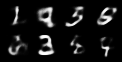

In [33]:
from IPython.display import Image
Image(filename='./generated/16_900.png',width=500,height=500) 

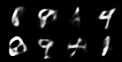

In [37]:
from IPython.display import Image
Image(filename='./generated/19_600.png',width=500,height=500) 

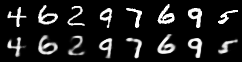

In [39]:
from IPython.display import Image
Image(filename='./samples/18_900.png',width=500,height=500) 

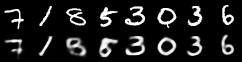

In [38]:
from IPython.display import Image
Image(filename='./samples/19_900.png',width=500,height=500) 